# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split

strategyArray = []
gainArray     = []
lossArray     = []
ampNumber     = 4

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.3, random_state = 5)
    return X_train, X_test, y_train, y_test

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

X_train, X_test, y_train, y_test = loadDataset()

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i]) 
                lossError += getLossError(predicted[i + 1], expected[i + 1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    X_train, X_test, y_train, y_test = loadDataset()
    gainErrors, lossErrors           = crossValidate(strategy, X_train, y_train)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = gainArray

    axis.boxplot(data)
    axis.set_title("Gain error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = lossArray

    axis.boxplot(data)
    axis.set_title("Loss error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotDistribution(regressor):
    X_train, X_test, y_train, y_test = loadDataset()
    regressor.fit(X_train, y_train)

    predicted = regressor.predict(X_test)
    fig, axis = plt.subplots(figsize = (10, 5))
    vGain     = np.vectorize(invertGainNorm)
    vLoss     = np.vectorize(invertLossNorm)
    
    axis.scatter(vGain(y_test[:, 0]), vLoss(y_test[:, 1]))
    axis.scatter(vGain(predicted[:, 0]), vLoss(predicted[:, 1]), c = "m")

    axis.set_title(strategyArray[-1])
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

In [8]:
def plotGainDistribution(regressor):
    X_train, X_test, y_train, y_test = loadDataset()

    predicted = regressor.predict(X_test)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(y_test[:, 0]), vFunc(predicted[:, 0]))
    axis.set_title("Gain Distribution - {}".format(strategyArray[-1]))
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [9]:
def plotLossDistribution(regressor):
    X_train, X_test, y_train, y_test = loadDataset()

    predicted = regressor.predict(X_test)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(y_test[:, 1]), vFunc(predicted[:, 1]), c = "m")
    axis.set_title("Loss Distribution - {}".format(strategyArray[-1]))
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [10]:
gainArray = []
lossArray = []

[1.57486725 1.60199039 1.57789213 1.5660421  1.69437883] => 1.60 (+/- 0.09)
[1.80610199 1.73234675 1.77946829 1.81149939 1.76099297] => 1.78 (+/- 0.06)


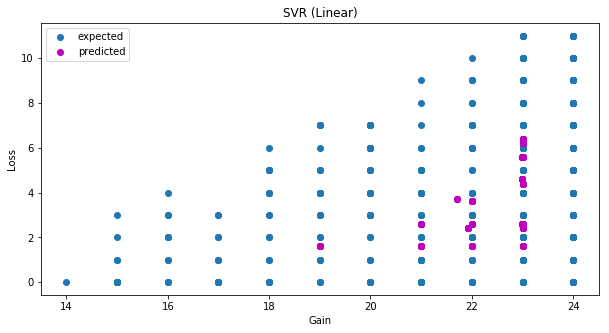

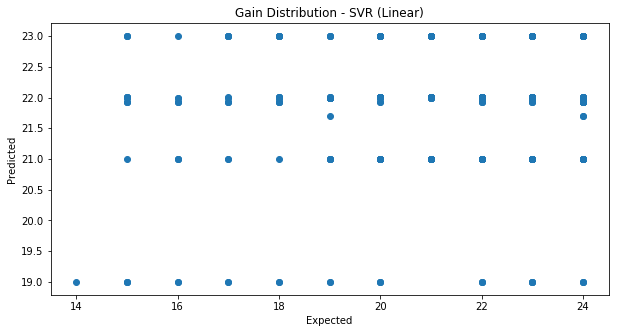

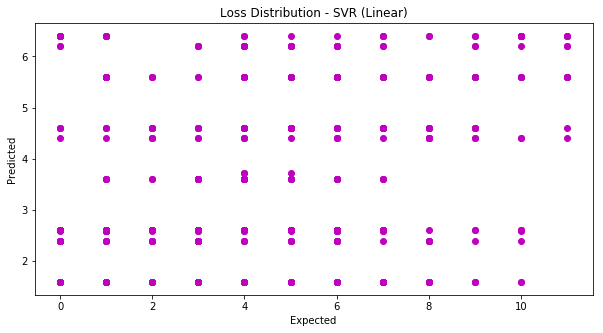

In [11]:
linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)
strategyArray.append("SVR (Linear)")
plotDistribution(linearSVR)
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[1.87551096 1.85874995 1.84082765 1.82467894 1.94824238] => 1.87 (+/- 0.09)
[2.05294524 2.03503381 2.05353584 2.08885619 2.03924545] => 2.05 (+/- 0.04)


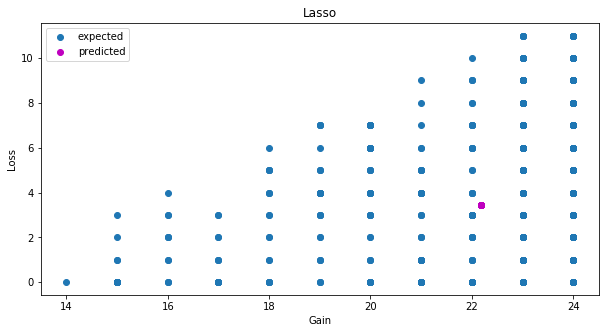

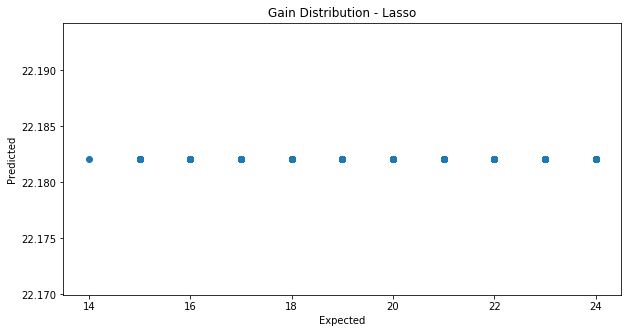

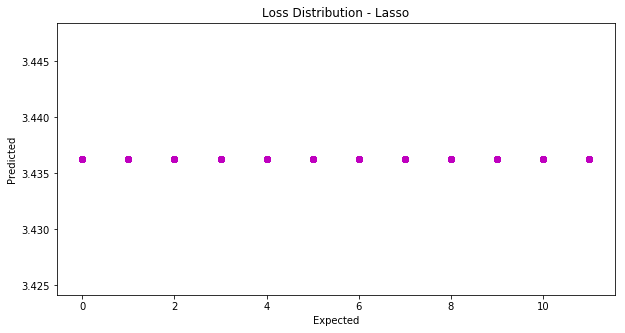

In [12]:
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)
strategyArray.append("Lasso")
plotDistribution(lasso)
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[1.86253351 1.84672687 1.82073078 1.81348445 1.93923093] => 1.86 (+/- 0.09)
[1.98279408 1.96072675 1.99714569 2.01631825 1.96395395] => 1.98 (+/- 0.04)


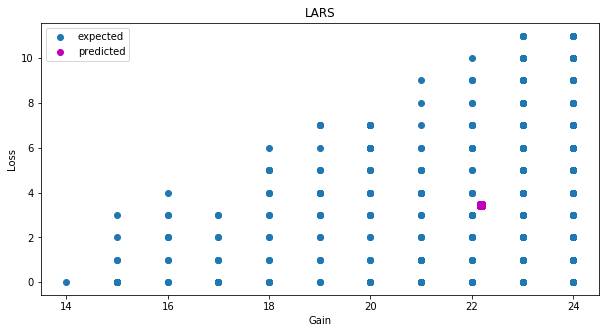

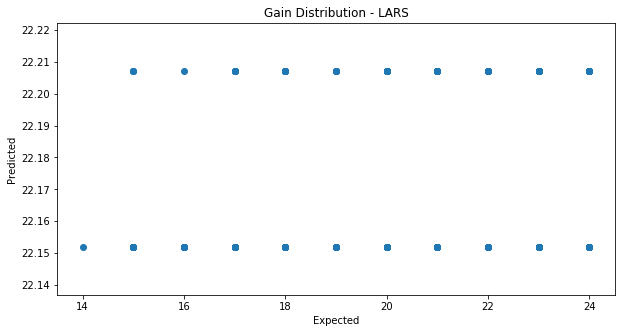

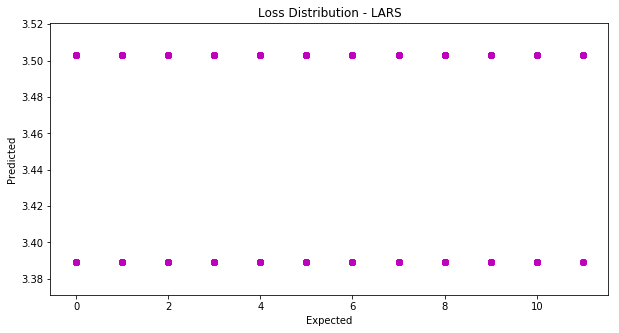

In [13]:
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)
strategyArray.append("LARS")
plotDistribution(lars)
plotGainDistribution(lars)
plotLossDistribution(lars)

[1.52880813 1.55584038 1.51208813 1.50103864 1.63079604] => 1.55 (+/- 0.09)
[1.59146793 1.5170329  1.54531236 1.59656454 1.51732013] => 1.55 (+/- 0.07)


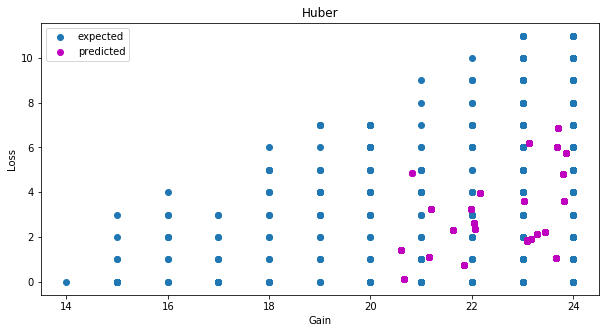

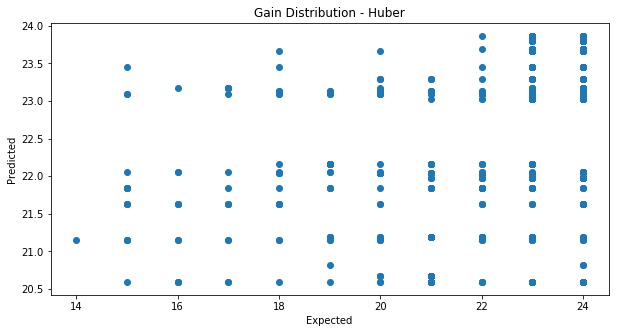

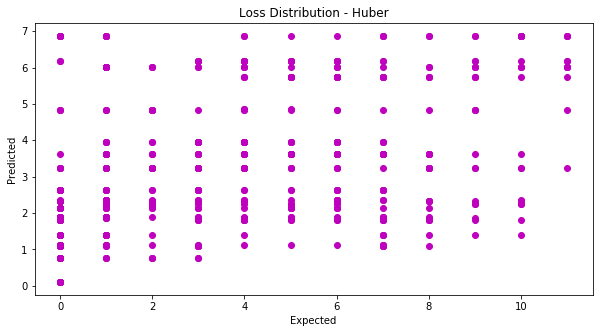

In [14]:
huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
trainModel(huber)
strategyArray.append("Huber")
plotDistribution(huber)
plotGainDistribution(huber)
plotLossDistribution(huber)

[1.64689441 1.65807453 1.63649068 1.6552795  1.69596273] => 1.66 (+/- 0.04)
[1.73354037 1.68757764 1.71863354 1.73416149 1.71102484] => 1.72 (+/- 0.03)


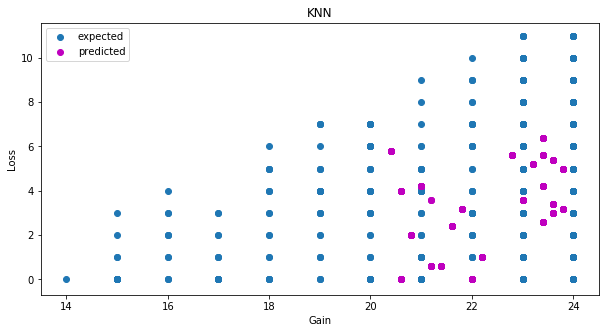

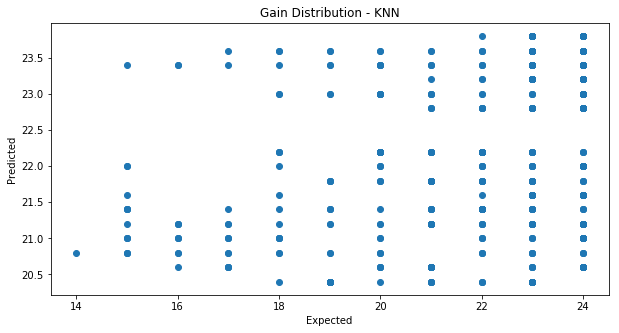

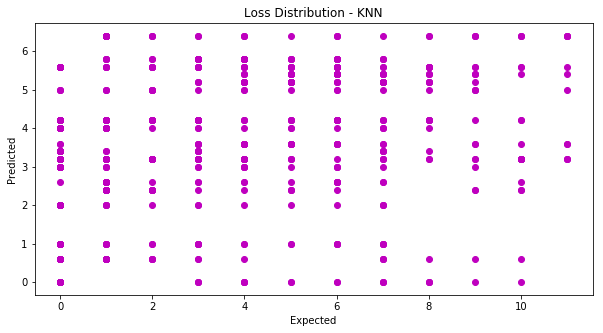

In [15]:
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)
strategyArray.append("KNN")
plotDistribution(knn)
plotGainDistribution(knn)
plotLossDistribution(knn)

[1.59184489 1.60507803 1.5867952  1.5798818  1.67525706] => 1.61 (+/- 0.07)
[1.60887827 1.55355264 1.5864288  1.65807714 1.57552436] => 1.60 (+/- 0.07)


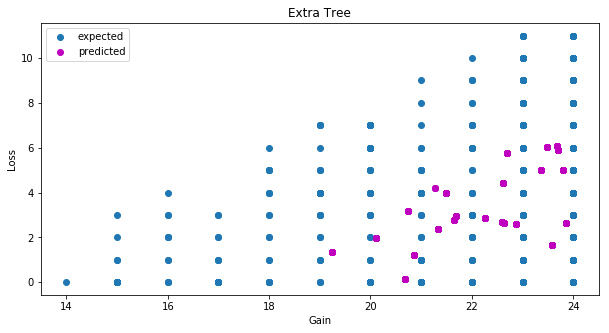

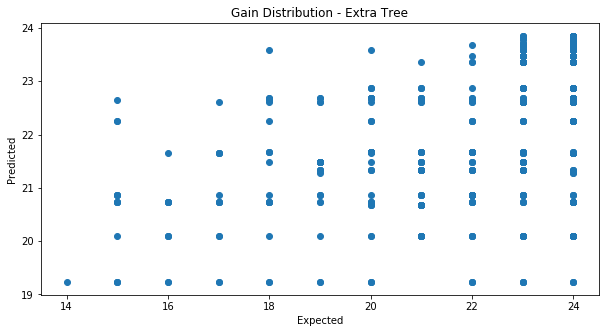

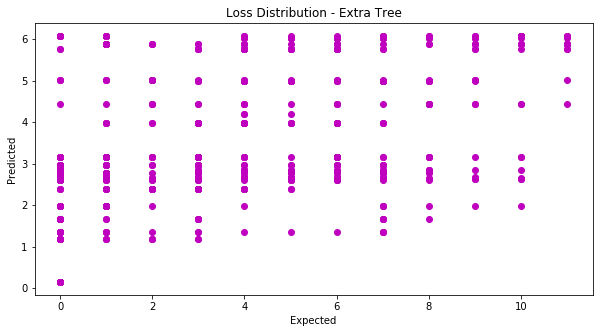

In [16]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
trainModel(bret)
strategyArray.append("Extra Tree")
plotDistribution(bret)
plotGainDistribution(bret)
plotLossDistribution(bret)

[1.59297632 1.6053876  1.58942069 1.58111731 1.67666641] => 1.61 (+/- 0.07)
[1.60937033 1.55386894 1.5889322  1.65958567 1.57565971] => 1.60 (+/- 0.07)


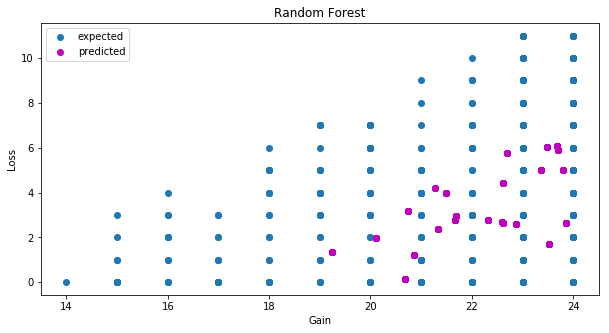

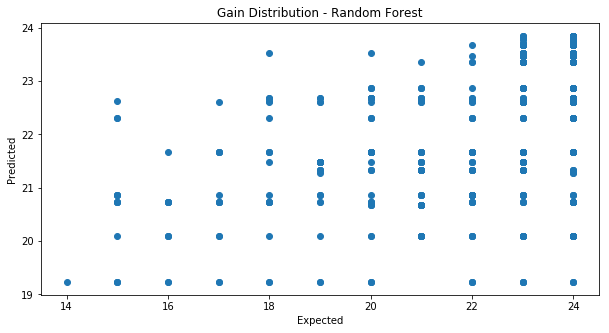

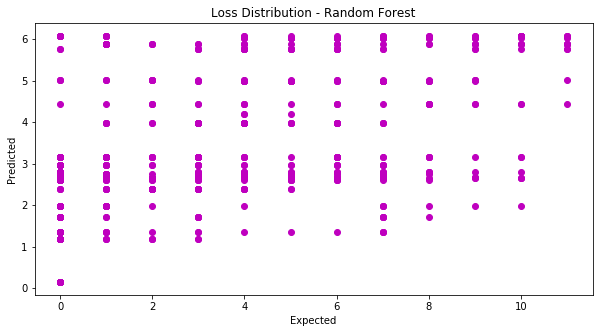

In [17]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
trainModel(randomForest)
strategyArray.append("Random Forest")
plotDistribution(randomForest)
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

# Plotting error boxplots

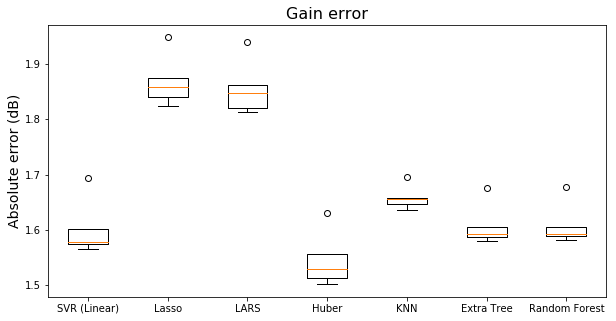

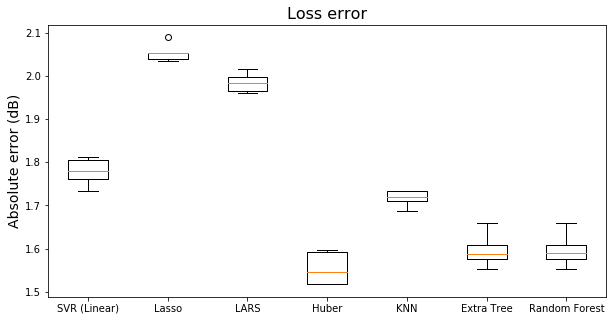

In [18]:
plotGainError()
plotLossError()